http://preview.d2l.ai/d2l-en/master/chapter_optimization/lr-scheduler.html

In [1]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, lr_scheduler, np, npx
from mxnet.gluon import nn
npx.set_np()

net = nn.HybridSequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120, activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10))
net.hybridize()
loss = gluon.loss.SoftmaxCrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# The code is almost identical to `d2l.train_ch6` that defined in the lenet
# section of chapter convolutional neural networks
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device):
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

train loss 0.139, train acc 0.948, test acc 0.867


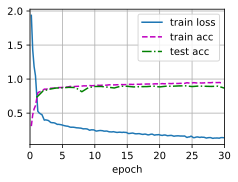

In [2]:
lr, num_epochs = 0.3, 30
net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

In [3]:
trainer.set_learning_rate(0.1)
print(f'learning rate is now {trainer.learning_rate:.2f}')

learning rate is now 0.10


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

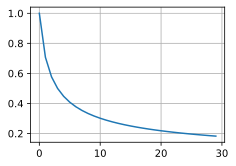

In [5]:
scheduler = SquareRootScheduler(lr=1.0)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

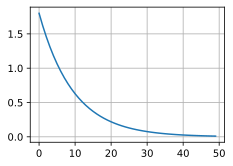

In [6]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(np.arange(50), [scheduler(t) for t in range(50)])

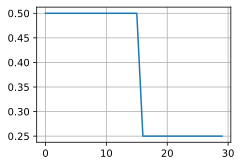

In [7]:
scheduler = lr_scheduler.MultiFactorScheduler(step=[15, 30], factor=0.5,
                                              base_lr=0.5)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.184, train acc 0.931, test acc 0.903


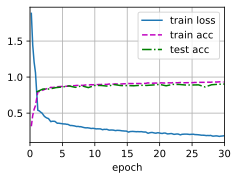

In [8]:
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

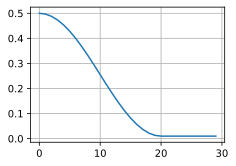

In [9]:
scheduler = lr_scheduler.CosineScheduler(max_update=20, base_lr=0.5,
                                         final_lr=0.01)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.430, train acc 0.841, test acc 0.834


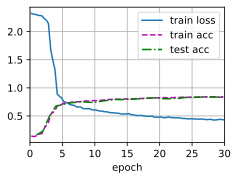

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

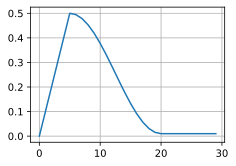

In [11]:
scheduler = lr_scheduler.CosineScheduler(20, warmup_steps=5, base_lr=0.5,
                                         final_lr=0.01)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.342, train acc 0.878, test acc 0.873


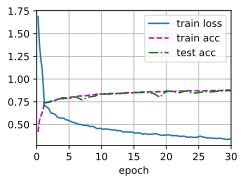

In [12]:
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)